# OC PROJET 5 - AUTOMATICALLY CATEGORIZE QUESTIONS
#### CLEANING AND ANALYSIS NOTEBOOK
<br></br>
### SOMMAIRE
- <a href="#C1">I. Nettoyage des données</a>
    
- <a href="#C2">II. Text Preprocessing</a>

- <a href="#C3">III. Feature Engineering</a>
    
- <a href="#C4">IV. Exploration des données</a>
    - 1. Analyse Univariée
    - 2. Analyse Multivariée
    - 3. Matrice des corrélations
    - 4. ACP

# <a name="C1">I. Nettoyage et fusion des données</a>

<font size="5">1. Importation des librairies</font>

In [1]:
# importation des librairies
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import font_manager as rcParams
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import time

<font size="5">2. Paramétrages Data Visualisation</font>

In [2]:
# Ajouter une ombre à la police
shadow = path_effects.withSimplePatchShadow(offset = (1, - 0.75), 
shadow_rgbFace = 'darkblue', alpha = 0.25)

# changer la police dans les graphiques, les couleurs 
# et augmenter la résolution d'affichage
plt.rcParams['font.family'] = 'Ebrima'
plt.rcParams['text.color'] = 'white'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.style.use('dark_background')

# set le theme seaborn
sns.set_style('darkgrid', {'axes.facecolor': '0.2',
'text.color': 'white', 'figure.figsize': (20, 16)})
plt.rcParams['figure.facecolor'] = '0.2'

# suppression de l'affichage max des colonnes
pd.set_option('display.max_columns', None)

<font size="5">3. Requêtes SQL</font>

Voici les deux requêtes SQL qui m'ont permis de récupérer les données.
Les requêtes étant limité à 50000 échantillons par query, j'en ai donc effectuer deux afin d'avoir 100.000 échantillons, ce qui est recommandé par sci-kit learn lorsque que l'on veux faire de la classification afin d'augmenter les possibilités : 
https://scikit-learn.org/stable/_static/ml_map.png

La première requete récupère les 50000 premiers échantillons de la table Posts avec un ordre sur l'id ascendant, la deuxième requête fait la même chose avec un ordre descendant.

SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, AnswerCount, CreationDate, LastActivityDate, CommentCount
FROM Posts
WHERE PostTypeId = 1 
  AND ViewCount > 100 
  AND Score > 3 
  AND AnswerCount > 0 
  AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 
  AND CommentCount > 0
ORDER BY Id ASC

SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, AnswerCount, CreationDate, LastActivityDate, CommentCount
FROM Posts
WHERE PostTypeId = 1 
  AND ViewCount > 100 
  AND Score > 3 
  AND AnswerCount > 0 
  AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5 
  AND CommentCount > 0
ORDER BY Id DESC

<font size="5">4. Dataframe</font>

In [3]:
df1 = pd.read_csv('QueryResultsAsc.csv')
df2 = pd.read_csv('QueryResultsDesc.csv')

In [4]:
# Fusion des DataFrames df1 et df2 sur la colonne commune
df = pd.concat([df1, df2])
df.shape

(100000, 10)

In [45]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opa...,<c#><floating-point><type-conversion><double><decimal>,4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4
1,Calculate relative time in C#,"<p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n<ul>...",<c#><datetime><time><datediff><relative-time-span>,11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3
2,Determine a user's timezone,<p>Is there a standard way for a web server to be able to determine a user's timezone within a w...,<html><browser><timezone><user-agent><timezone-offset>,13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10
3,What is the fastest way to get the value of π?,"<p>I'm looking for the fastest way to obtain the value of π, as a personal challenge. More speci...",<performance><algorithm><language-agnostic><unix><pi>,19,351,68134,23,2008-08-01 05:21:22,2023-03-27 07:55:50,17
4,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API to work properly in C++ on z/OS.</p>\n<p>Although...,<c++><c><sockets><mainframe><zos>,25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1


In [46]:
df.isnull().sum()

Title               0
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
AnswerCount         0
CreationDate        0
LastActivityDate    0
CommentCount        0
dtype: int64

In [47]:
df.loc[df.duplicated(keep = False),:]

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount


In [48]:
df.dtypes

Title               object
Body                object
Tags                object
Id                   int64
Score                int64
ViewCount            int64
AnswerCount          int64
CreationDate        object
LastActivityDate    object
CommentCount         int64
dtype: object

In [49]:
df.describe()

,Id,Score,ViewCount,AnswerCount,CommentCount
count,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.00000
mean,3.140196e+07,24.862830,2.314290e+04,3.326830,3.57137
std,2.647337e+07,172.320926,1.223877e+05,3.746832,3.23915
min,4.000000e+00,4.000000,1.010000e+02,1.000000,1.00000
25%,5.628995e+06,5.000000,1.734000e+03,1.000000,1.00000
50%,2.863875e+07,7.000000,4.754000e+03,2.000000,3.00000
75%,5.611157e+07,13.000000,1.338200e+04,4.000000,5.00000
max,7.639181e+07,25651.000000,1.278321e+07,134.000000,51.00000


# <a name="C2">II. Text Preprocessing</a>

Cette fonction va servir à effectuer un nettoyage principal du texte :
    - Suppression des balises HTML
    - Mettre le texte en minuscule
    - Supprimer la ponctuation
    - Stop words (mots vides)
    - Tokenization
    - Lemmatisation des mots

In [5]:
def preprocess_text(text):
    # Supprimer les balises HTML
    text = re.sub('<.*?>', '', text)
    
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Supprimer les mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoindre les tokens prétraités en une seule chaîne de texte
    processed_text = ' '.join(tokens)
    
    return processed_text

Cette fonction est similaire à la précédente sauf qu'elle va être utilisée pour traiter
le titre des questions, et garder les symboles + et # pour éviter d'omettre C# et C++

In [ ]:
def preprocess_title(text):
    # Supprimer les balises HTML
    text = re.sub('<.*?>', '', text)
    
    # Convertir en minuscules
    text = text.lower()
    
    # Supprimer la ponctuation et garder les symboles + et #
    text = re.sub(r'[^\w\s+#]', '', text)
    
    # Supprimer les mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoindre les tokens prétraités en une seule chaîne de texte
    processed_text = ' '.join(tokens)
    
    return processed_text

In [6]:
df['body_preprocess'] = df['Body'].apply(preprocess_text)

In [7]:
df['title_preprocess'] = df['Title'].apply(preprocess_title)

In [8]:
pd.set_option('display.max_colwidth', None)
df['body_preprocess'].head(10)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [9]:
df['title_preprocess'].head(10)

0                                convert decimal double c#
1                               calculate relative time c#
2                                  determine user timezone
3                                  fastest way get value π
4                                 use c socket api c++ zos
5                               decoding tsql cast c#vbnet
6                        export data sql server 2005 mysql
7                generate list possible permutation string
8    meaning type safety warning certain java generic cast
9        definitive guide formbased website authentication
Name: title_preprocess, dtype: object

Cette fonction va permettre de nettoyer les mots inexistants 
sur le texte des questions à l'aide de la librairie word de nltk.corpus

In [10]:
def nettoyer_texte(texte):
    mots_valides = set(words.words())

    mots = nltk.word_tokenize(texte)
    mots_nettoyes = [mot for mot in mots if mot.lower() in mots_valides]
    texte_nettoye = ' '.join(mots_nettoyes)

    return texte_nettoye

texte = 'want assign decimal variable quottransquot double variable quotthisopacityquot decimal trans trackbar1value 5000 thisopacity trans build app give following error cannot implicitly convert type decimal double'
texte_nettoye = nettoyer_texte(texte)
print(texte_nettoye)

want assign decimal variable double variable decimal build give following error can not implicitly convert type decimal double


In [11]:
df['body_clean'] = df['body_preprocess'].apply(nettoyer_texte)

In [12]:
df['body_clean']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  want assign decimal variable double variable decimal build give following error can not implicitly convert type decimal double
1                                                                                                                                                                     

In [13]:
# sauvegarde du dataframe
df.to_csv('QueryResultsClean.csv', index = False)

# <a name="C3">III. Feature Engineering</a>

In [14]:
df = pd.read_csv('QueryResultsClean.csv')

In [15]:
# Fonction pour extraire les tags d'une chaîne de caractères
def extract_tags(tag_string):
    tags = re.findall(r'<(.*?)>', tag_string)
    return tags

# Application de la fonction d'extraction des tags à la colonne 'Tags' du DataFrame
df['Tags'] = df['Tags'].apply(extract_tags)

# Extraction des tags uniques à partir de toutes les lignes
unique_tags = set([tag for tags_list in df['Tags'] for tag in tags_list])

# Affichage des tags uniques
print("Tags uniques :")
for tag in unique_tags:
    print(tag)

Tags uniques :
probe
checkstyle
statements
event-flow
lifelines
http-put
watson-conversation
jls
spring-cloud-consul
fingerprintjs2
system-shutdown
handlers
macros
inheritance
function-composition
view-scope
onedrive
unirest
document-ready
symbolic-math
garbage-collection
shared-resource
custom-formatting
avl-tree
data-binding
git-diff
datepart
nstrackingarea
web-farm
watch-face-api
rebase
global-asax
helmfile
assemblyresolve
simplehttpserver
ant-design-pro
regex-greedy
railstutorial.org
google-location-services
universal
econnreset
memory-limit
django-fixtures
cucumberjs
system.diagnostics
json-ld
rights-management
shell
jetty
openmpi
scroll-lock
ambari
gettimeofday
nslayoutconstraint
jsoup
opensearch
sched-deadline
azure-tablequery
qt-signals
queuing
speculative-execution
msdtc
knuth-morris-pratt
google-json-api
sqldatareader
zimbra
supertest
foxpro
timer
django-filter
detection
elmah
gdal
pre-rendering
rswag
integer-division
return-value
visual-c++-2012
qlistview
msr
saas
recorder
l

In [16]:
list_tags = [tag for tags_list in df['Tags'] for tag in tags_list]

In [17]:
len(list_tags)

500001

In [18]:
counter = Counter(list_tags)

In [20]:
counter.most_common(50)

[('c#', 12348),
 ('java', 11296),
 ('python', 10762),
 ('javascript', 10534),
 ('c++', 8609),
 ('.net', 6222),
 ('android', 5972),
 ('ios', 4729),
 ('html', 4037),
 ('php', 3952),
 ('c', 3889),
 ('jquery', 2969),
 ('node.js', 2893),
 ('reactjs', 2816),
 ('iphone', 2801),
 ('css', 2669),
 ('linux', 2447),
 ('sql', 2362),
 ('performance', 2348),
 ('objective-c', 2339),
 ('asp.net', 2297),
 ('python-3.x', 2234),
 ('windows', 1946),
 ('spring', 1907),
 ('angular', 1853),
 ('swift', 1788),
 ('mysql', 1775),
 ('typescript', 1742),
 ('algorithm', 1698),
 ('arrays', 1637),
 ('sql-server', 1601),
 ('multithreading', 1593),
 ('xcode', 1554),
 ('spring-boot', 1534),
 ('json', 1483),
 ('ruby-on-rails', 1421),
 ('string', 1386),
 ('database', 1366),
 ('docker', 1362),
 ('macos', 1349),
 ('django', 1334),
 ('unit-testing', 1246),
 ('visual-studio', 1238),
 ('asp.net-core', 1234),
 ('amazon-web-services', 1212),
 ('wpf', 1202),
 ('r', 1196),
 ('ruby', 1182),
 ('gcc', 1157),
 ('pandas', 1089)]

In [21]:
# Obtention des 50 tags les plus courants
top_tags = counter.most_common(50)

# Création d'une liste des 50 tags les plus courants
common_tags = [tag for tag, count in top_tags]

# Sauvegarde de la liste des tags dans un fichier
with open('tags.txt', 'w') as file:
    for tag in common_tags:
        file.write(tag + '\n')

print("Liste des tags enregistrée dans le fichier 'tags.txt'.")

Liste des tags enregistrée dans le fichier 'tags.txt'.


In [22]:
common_tags

['c#',
 'java',
 'python',
 'javascript',
 'c++',
 '.net',
 'android',
 'ios',
 'html',
 'php',
 'c',
 'jquery',
 'node.js',
 'reactjs',
 'iphone',
 'css',
 'linux',
 'sql',
 'performance',
 'objective-c',
 'asp.net',
 'python-3.x',
 'windows',
 'spring',
 'angular',
 'swift',
 'mysql',
 'typescript',
 'algorithm',
 'arrays',
 'sql-server',
 'multithreading',
 'xcode',
 'spring-boot',
 'json',
 'ruby-on-rails',
 'string',
 'database',
 'docker',
 'macos',
 'django',
 'unit-testing',
 'visual-studio',
 'asp.net-core',
 'amazon-web-services',
 'wpf',
 'r',
 'ruby',
 'gcc',
 'pandas']

In [23]:
pd.set_option('display.max_colwidth', 100)

df.head()

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount,body_preprocess,title_preprocess,body_clean
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opa...,"[c#, floating-point, type-conversion, double, decimal]",4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4,want assign decimal variable quottransquot double variable quotthisopacityquot decimal trans tra...,convert decimal double c#,want assign decimal variable double variable decimal build give following error can not implicit...
1,Calculate relative time in C#,"<p>Given a specific <code>DateTime</code> value, how do I display relative time, like:</p>\n<ul>...","[c#, datetime, time, datediff, relative-time-span]",11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3,given specific datetime value display relative time like 2 hour ago 3 day ago month ago,calculate relative time c#,given specific value display relative time like hour ago day ago month ago
2,Determine a user's timezone,<p>Is there a standard way for a web server to be able to determine a user's timezone within a w...,"[html, browser, timezone, user-agent, timezone-offset]",13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10,standard way web server able determine user timezone within web page perhaps http header part us...,determine user timezone,standard way web server able determine user within web page perhaps header part string
3,What is the fastest way to get the value of π?,"<p>I'm looking for the fastest way to obtain the value of π, as a personal challenge. More speci...","[performance, algorithm, language-agnostic, unix, pi]",19,351,68134,23,2008-08-01 05:21:22,2023-03-27 07:55:50,17,im looking fastest way obtain value π personal challenge specifically im using way dont involve ...,fastest way get value π,looking way obtain value personal challenge specifically way dont involve define constant like n...
4,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API to work properly in C++ on z/OS.</p>\n<p>Although...,"[c++, c, sockets, mainframe, zos]",25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1,im issue getting c socket api work properly c zos although including syssocketh still get compil...,use c socket api c++ zos,issue getting c socket work properly c although still get compile time error telling defined mis...


In [24]:
def extract_tags(list_to_check):
    for tags in list_to_check:
        if tags in common_tags:
            return tags
    return ''

In [25]:
df['main_tag'] = df['Tags'].apply(extract_tags)

In [26]:
df_main_tag = df[df['main_tag'] != '']

In [27]:
df_main_tag = df_main_tag.drop(columns=['body_preprocess','Body'])

In [28]:
# Convertir les variables 'CreationDate' et 'LastActivityDate' en format de date
df_main_tag['CreationDate'] = pd.to_datetime(df_main_tag['CreationDate'])
df_main_tag['LastActivityDate'] = pd.to_datetime(df_main_tag['LastActivityDate'])

# Calculer la différence en jours entre les deux variables
df_main_tag['ActivityTime'] = (df_main_tag['LastActivityDate'] - df_main_tag['CreationDate']).dt.days

In [29]:
df_main_tag

,Title,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount,title_preprocess,body_clean,main_tag,ActivityTime
0,How to convert Decimal to Double in C#?,"[c#, floating-point, type-conversion, double, decimal]",4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4,convert decimal double c#,want assign decimal variable double variable decimal build give following error can not implicit...,c#,5151
1,Calculate relative time in C#,"[c#, datetime, time, datediff, relative-time-span]",11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3,calculate relative time c#,given specific value display relative time like hour ago day ago month ago,c#,5148
2,Determine a user's timezone,"[html, browser, timezone, user-agent, timezone-offset]",13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10,determine user timezone,standard way web server able determine user within web page perhaps header part string,html,4988
3,What is the fastest way to get the value of π?,"[performance, algorithm, language-agnostic, unix, pi]",19,351,68134,23,2008-08-01 05:21:22,2023-03-27 07:55:50,17,fastest way get value π,looking way obtain value personal challenge specifically way dont involve define constant like n...,performance,5351
4,How to use the C socket API in C++ on z/OS,"[c++, c, sockets, mainframe, zos]",25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1,use c socket api c++ zos,issue getting c socket work properly c although still get compile time error telling defined mis...,c++,5416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,Bootstrap 4 - Nav - Hiding extra menu items,"[jquery, html, css, twitter-bootstrap, bootstrap-4]",46477802,17,16932,7,2017-09-28 20:31:08,2019-03-17 11:49:07,4,bootstrap 4 nav hiding extra menu item,bootstrap layout similar many item want hidden added job problem also hide menu hide extra menu ...,jquery,534
99995,Check std::vector has duplicates,"[c++, algorithm, for-loop, vector, duplicates]",46477764,19,51315,7,2017-09-28 20:27:39,2022-06-29 10:51:43,11,check stdvector duplicate,want check vector integer duplicate return true try something like bool work since can not assig...,c++,1734
99997,Python subprocess check_output decoding specials characters,"[python, python-3.x, character-encoding, subprocess, special-characters]",46476677,6,9223,1,2017-09-28 19:13:38,2017-09-28 19:34:10,9,python subprocess check_output decoding special character,issue python try execute give output special character like try decode end give error cant decod...,python,0
99998,"In electron, how to upload a file from it's full filename","[javascript, node.js, file-upload, electron, axios]",46476474,4,3954,1,2017-09-28 18:58:53,2018-06-27 13:57:05,3,electron upload file full filename,electron button say contract look contract ie get need window problem file form data read issue ...,javascript,271


Dernière vérification et nettoyage avant la sauvegarde du 
dataframe qui servira pour les tests

In [30]:
df_main_tag.isnull().sum()

Title               0
Tags                0
Id                  0
Score               0
ViewCount           0
AnswerCount         0
CreationDate        0
LastActivityDate    0
CommentCount        0
title_preprocess    1
body_clean          1
main_tag            0
ActivityTime        0
dtype: int64

In [31]:
df_main_tag = df_main_tag.dropna()

In [33]:
df_main_tag.to_csv('QueryResultsFinal.csv', index = False)

# <a name="C4">IV. Exploration des données</a>

In [3]:
df = pd.read_csv('QueryResultsFinal.csv')

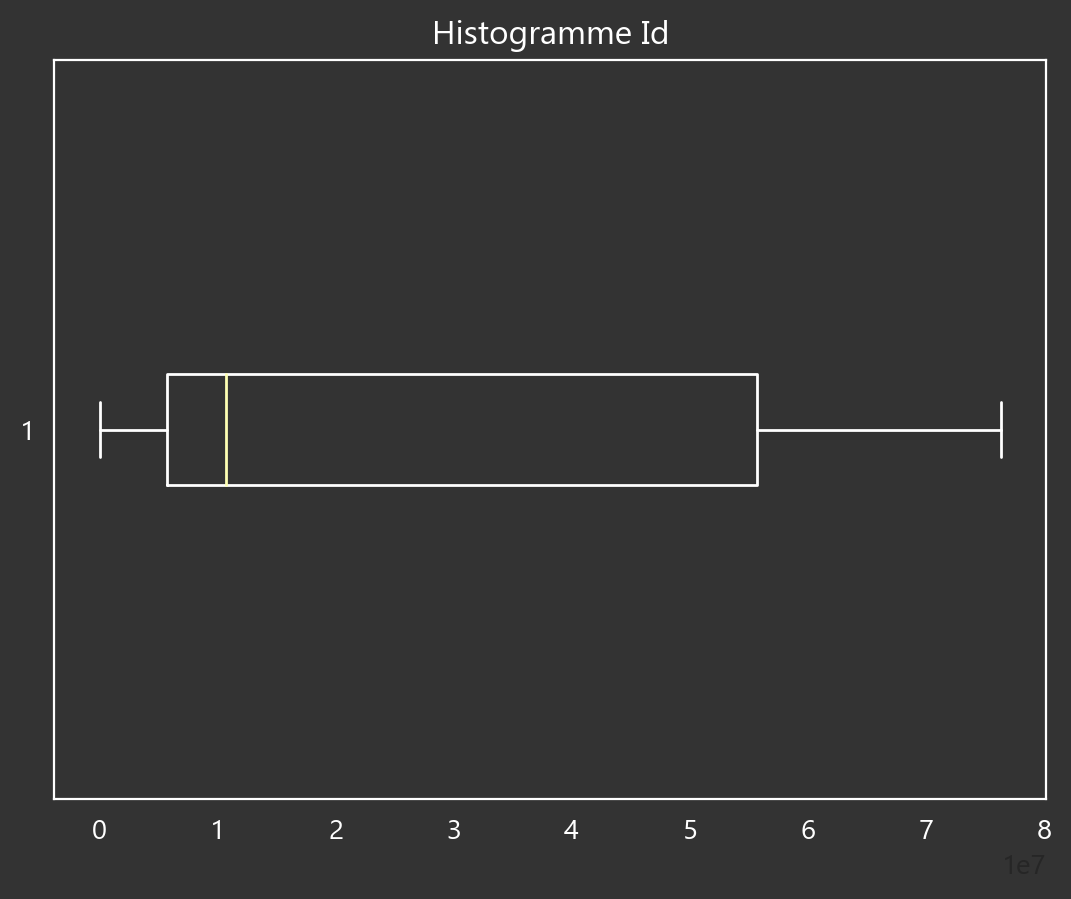

Id


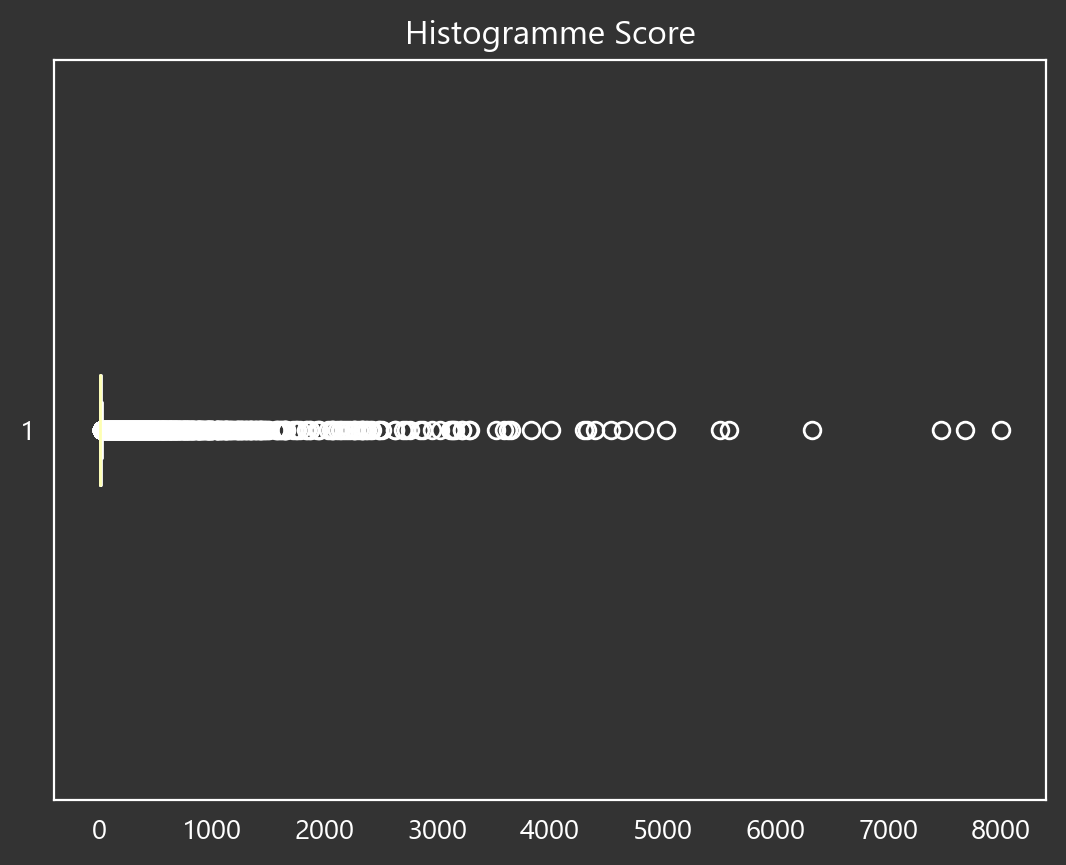

Score


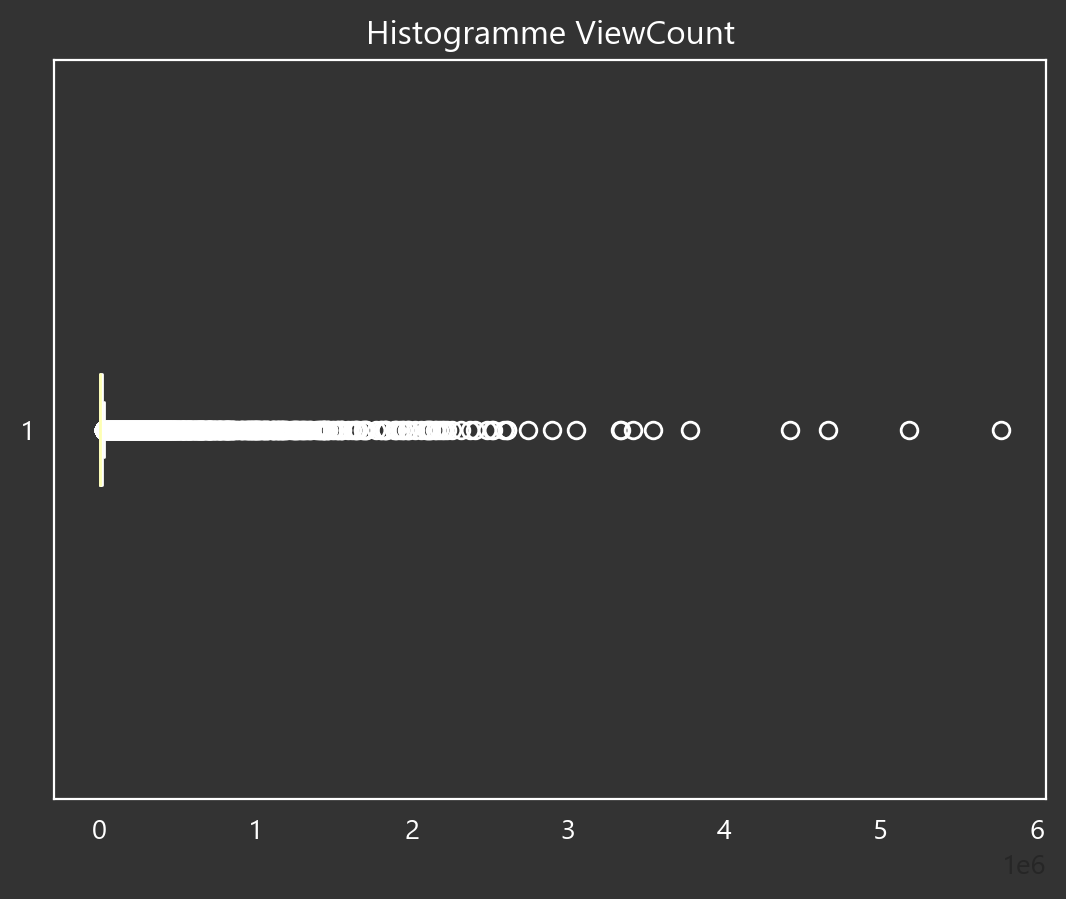

ViewCount


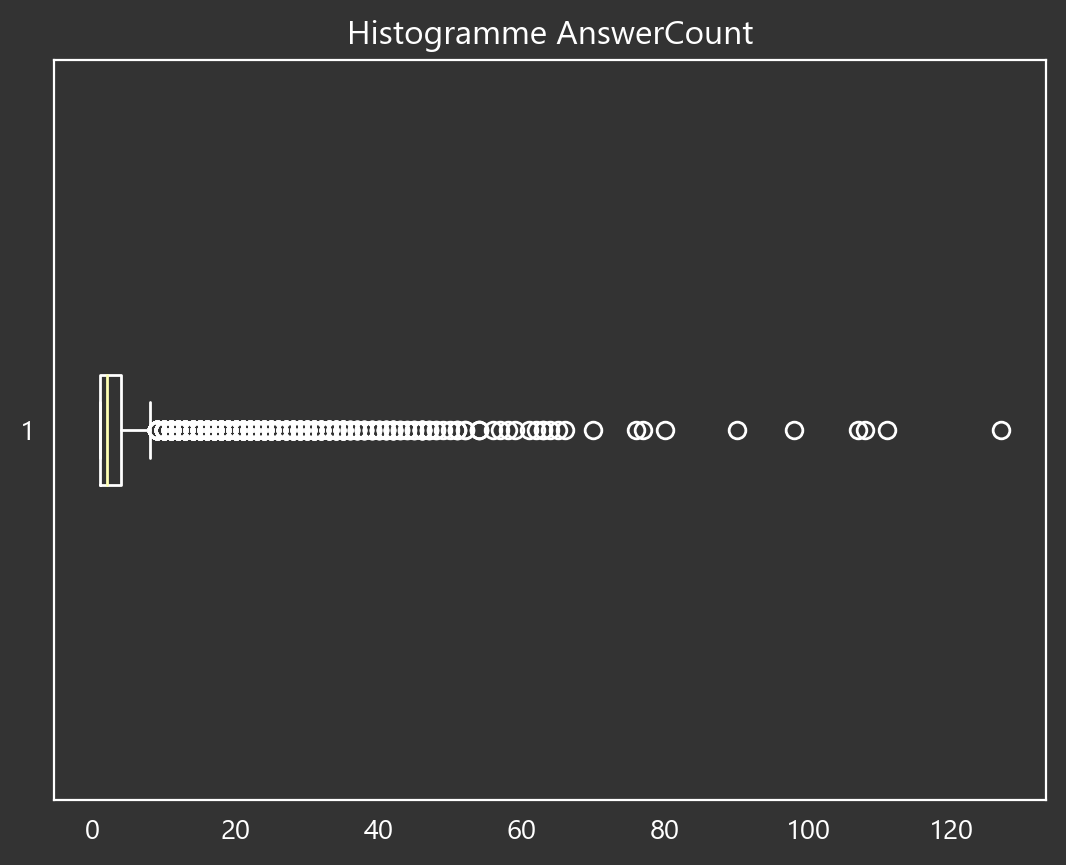

AnswerCount


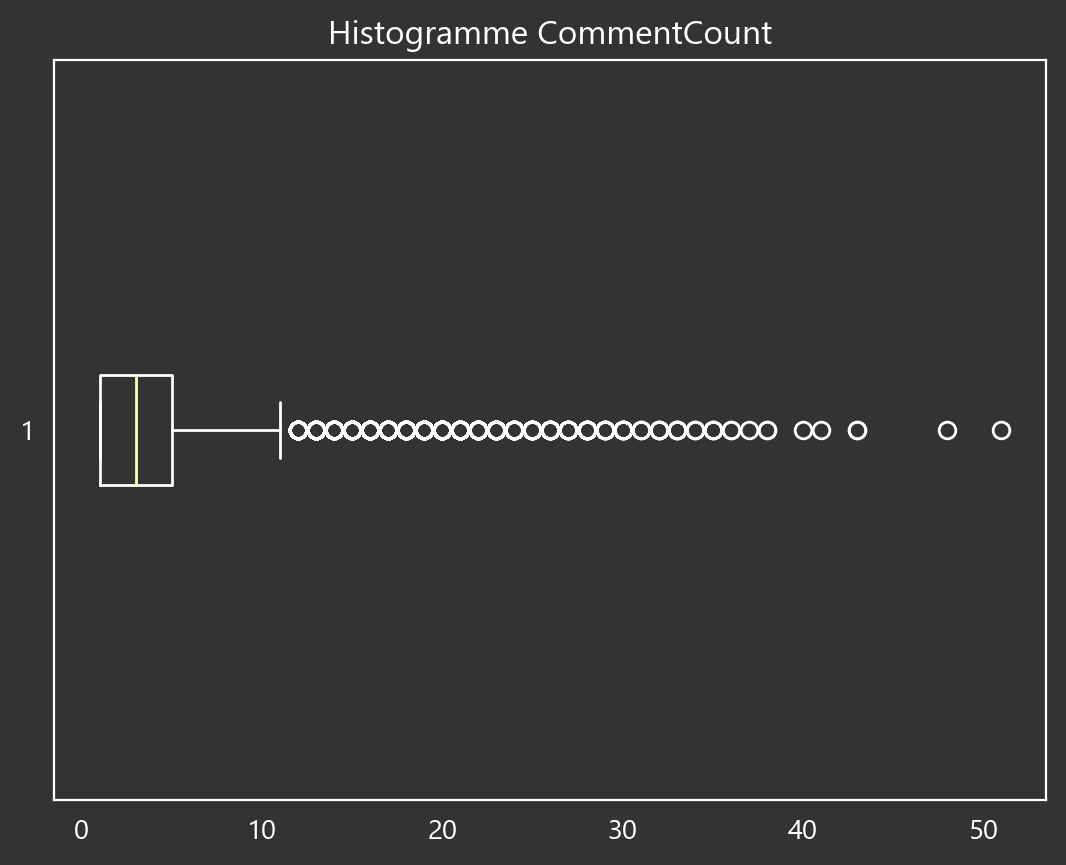

CommentCount


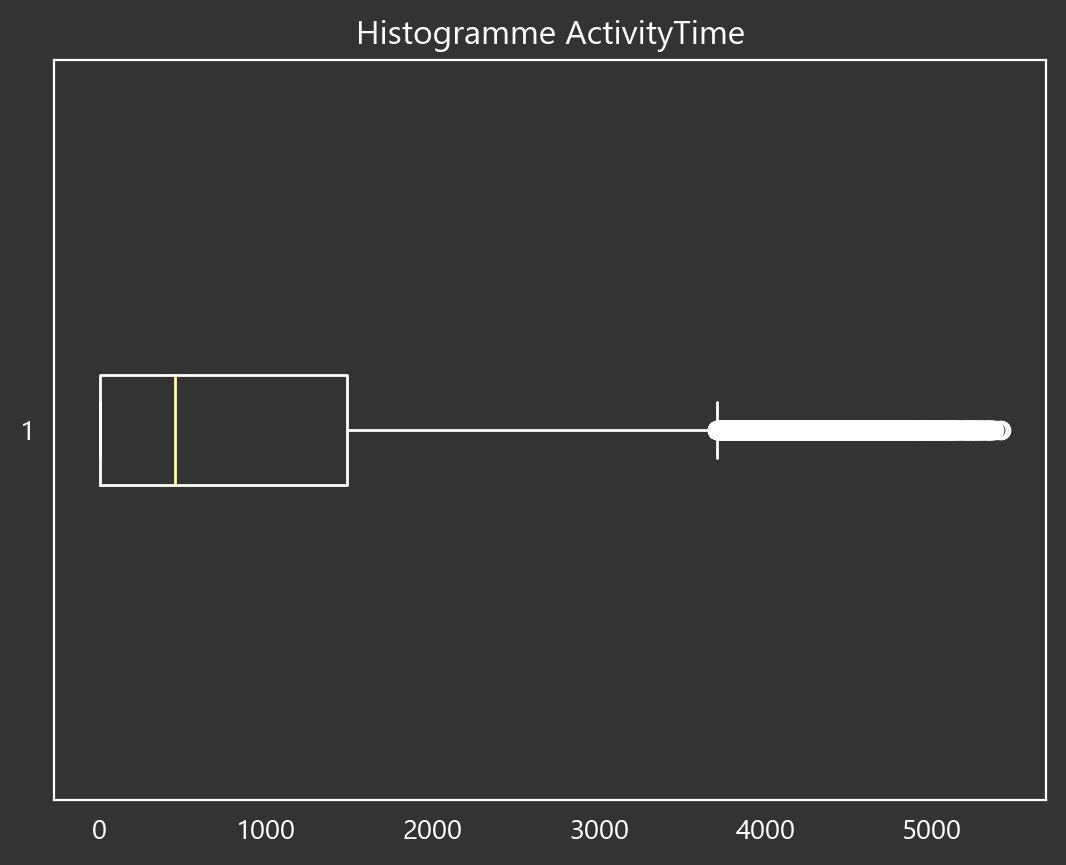

ActivityTime


In [19]:
plt.rcParams['font.family'] = 'Ebrima'
# on vérifie avec les boxplot
list_columns = ['Id', 'Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'ActivityTime']

for columns_name in list_columns:
    plt.grid(False)
    plt.title(f"Histogramme {columns_name}")
    plt.boxplot(df[columns_name], vert = False)
    plt.xticks(color = 'white')
    plt.yticks(color = 'white')
    plt.show()
    print(columns_name)

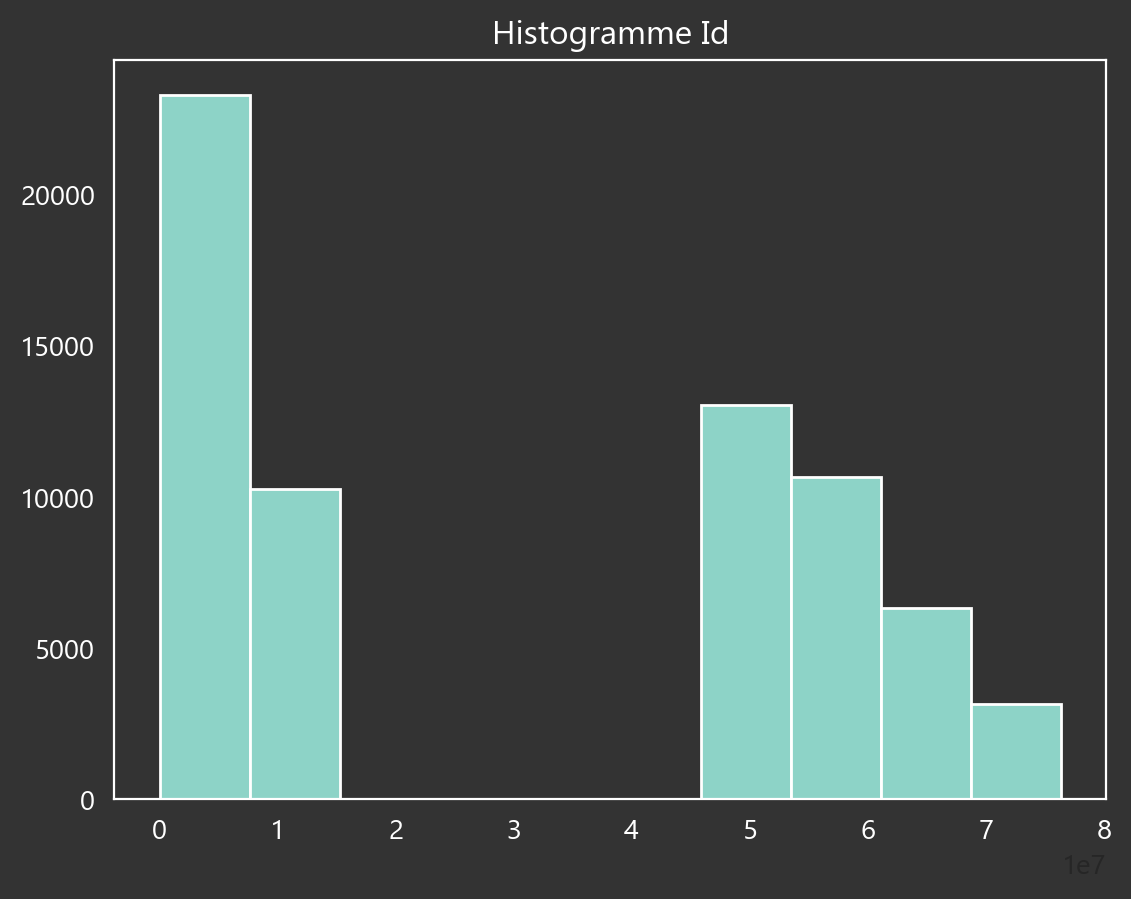

Id


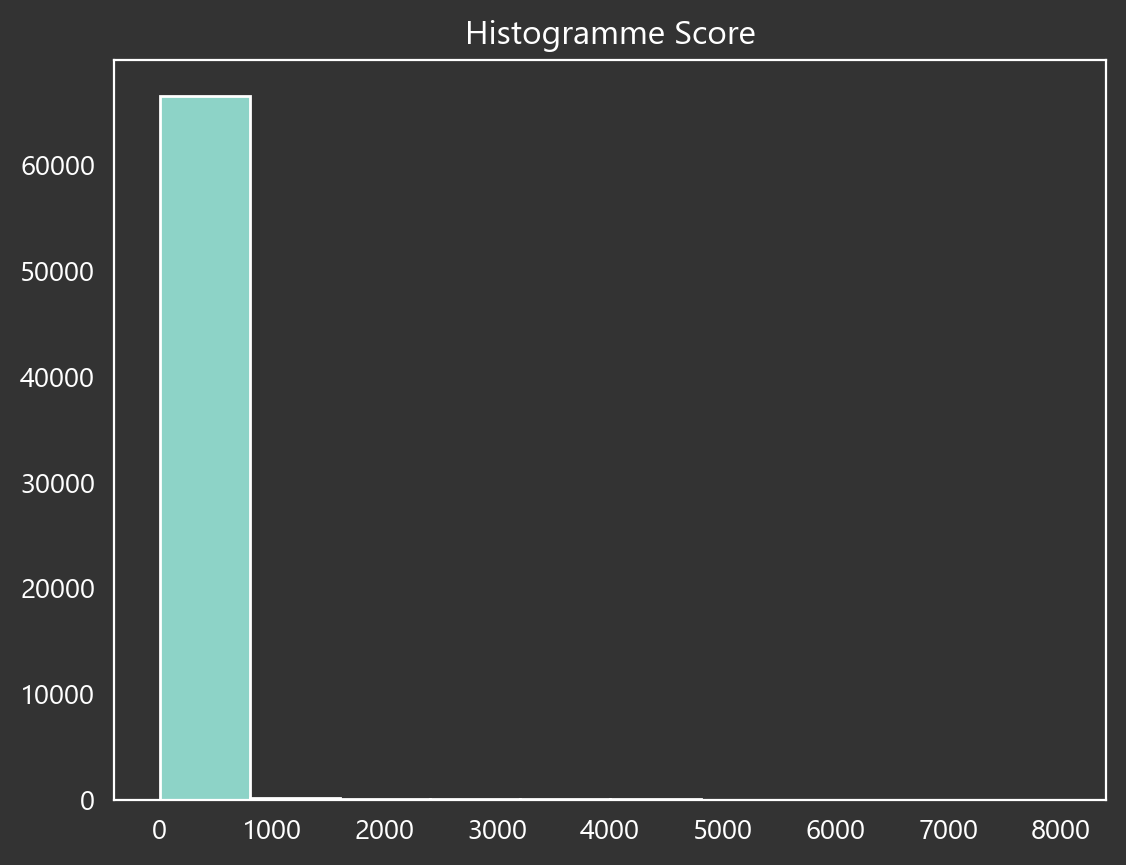

Score


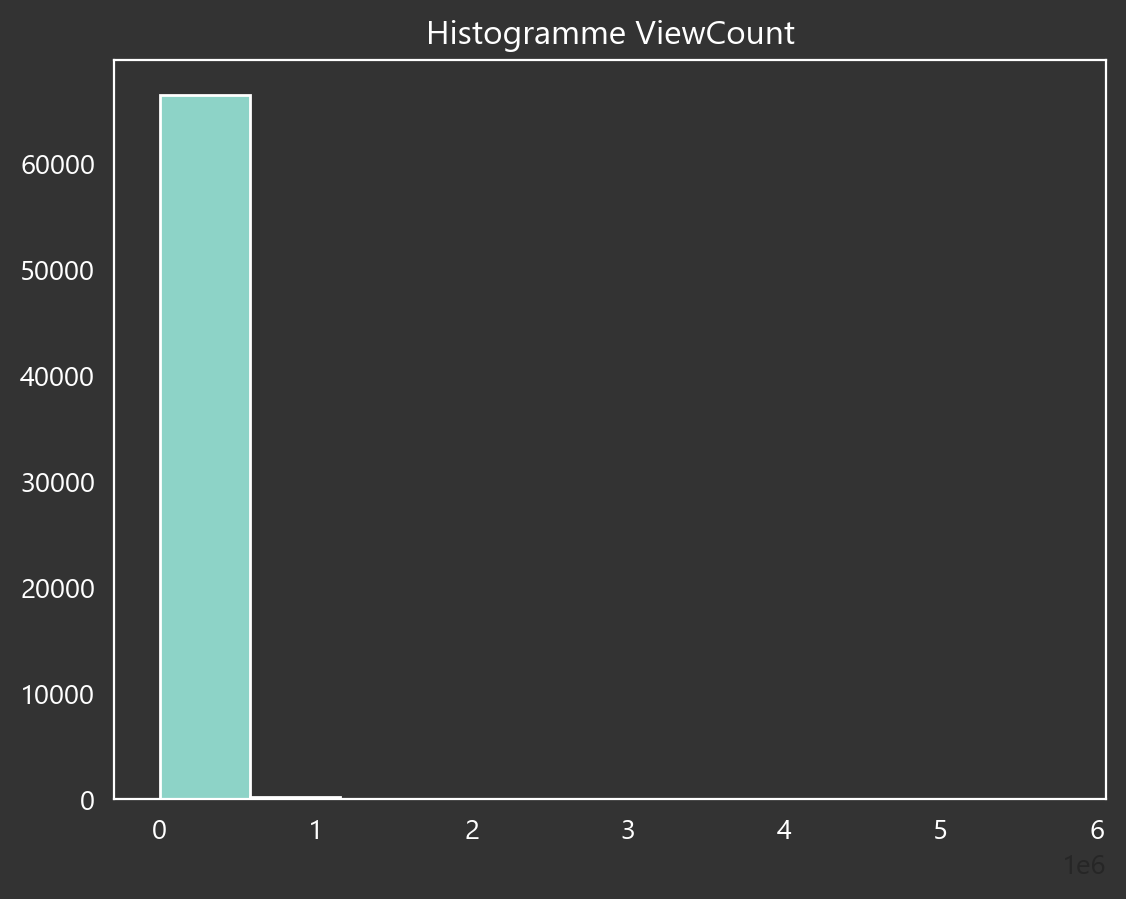

ViewCount


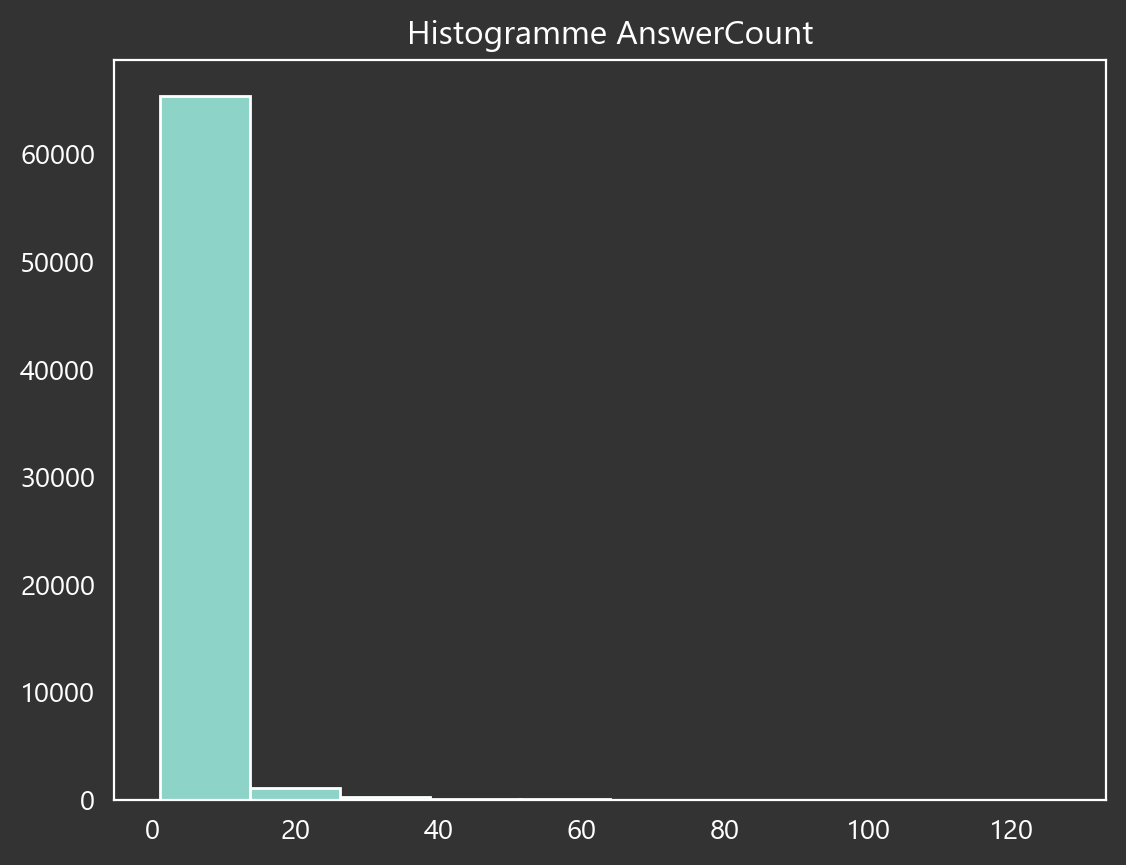

AnswerCount


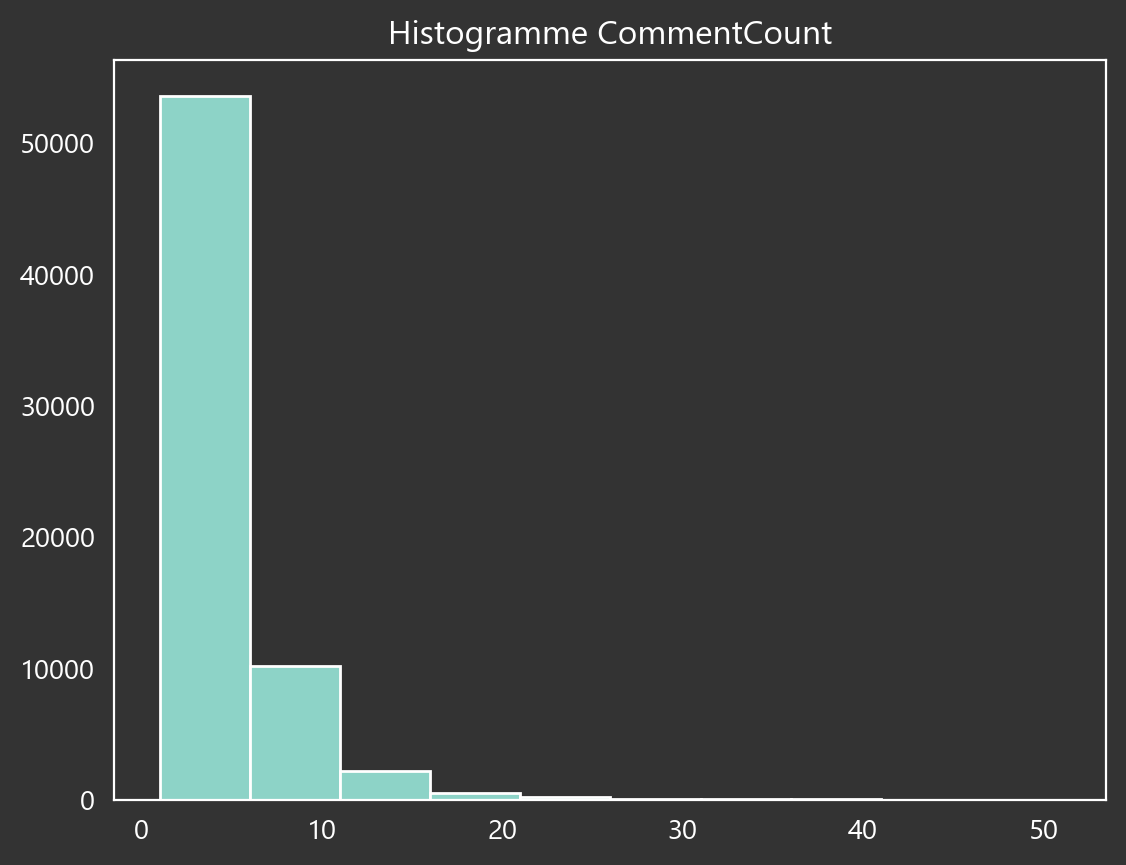

CommentCount


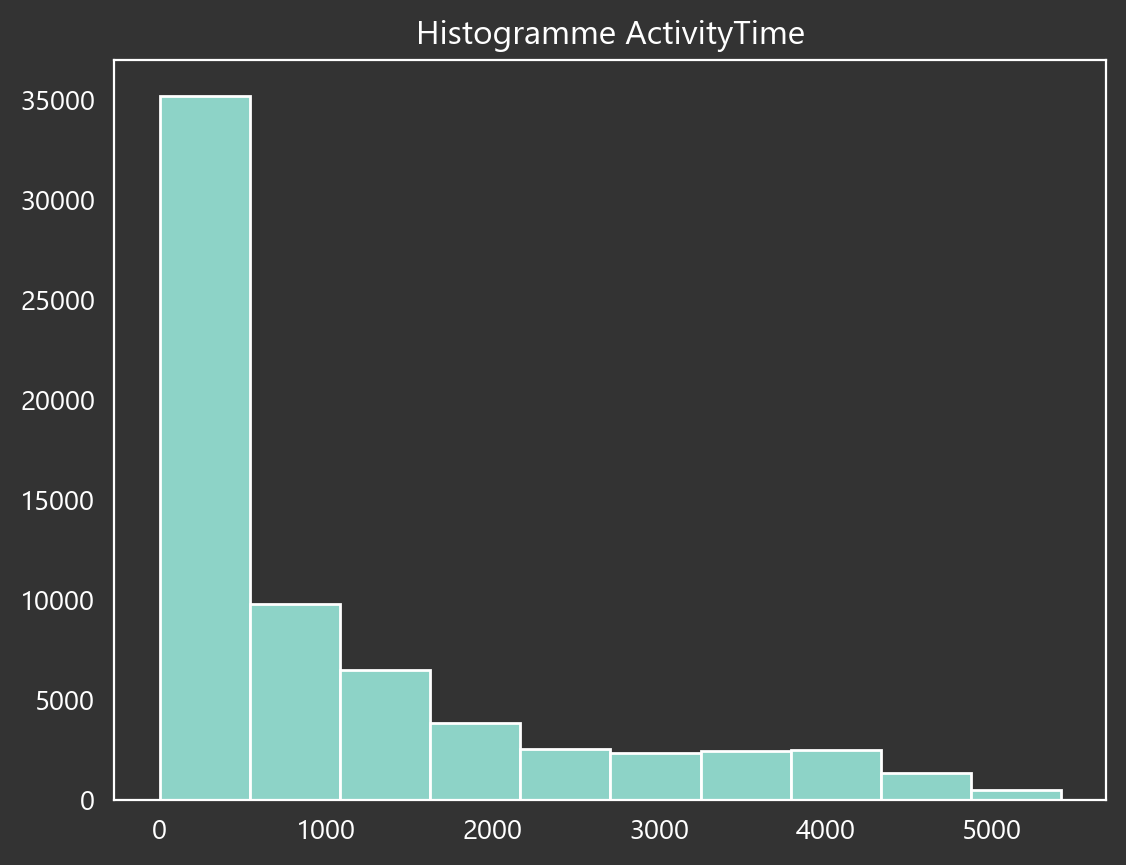

ActivityTime


In [72]:
# on vérifie que la distribution des variables est correcte
list_columns = ['Id', 'Score', 'ViewCount', 'AnswerCount', 'CommentCount', 'ActivityTime']

for columns_name in list_columns:
    plt.title(f"Histogramme {columns_name}")
    plt.hist(df[columns_name])
    plt.xticks(color = 'white')
    plt.yticks(color = 'white')
    plt.grid(False)
    plt.show()
    print(columns_name)

C:\Users\omira\AppData\Local\Temp\ipykernel_1932\1904223183.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), center = 1, annot = True,


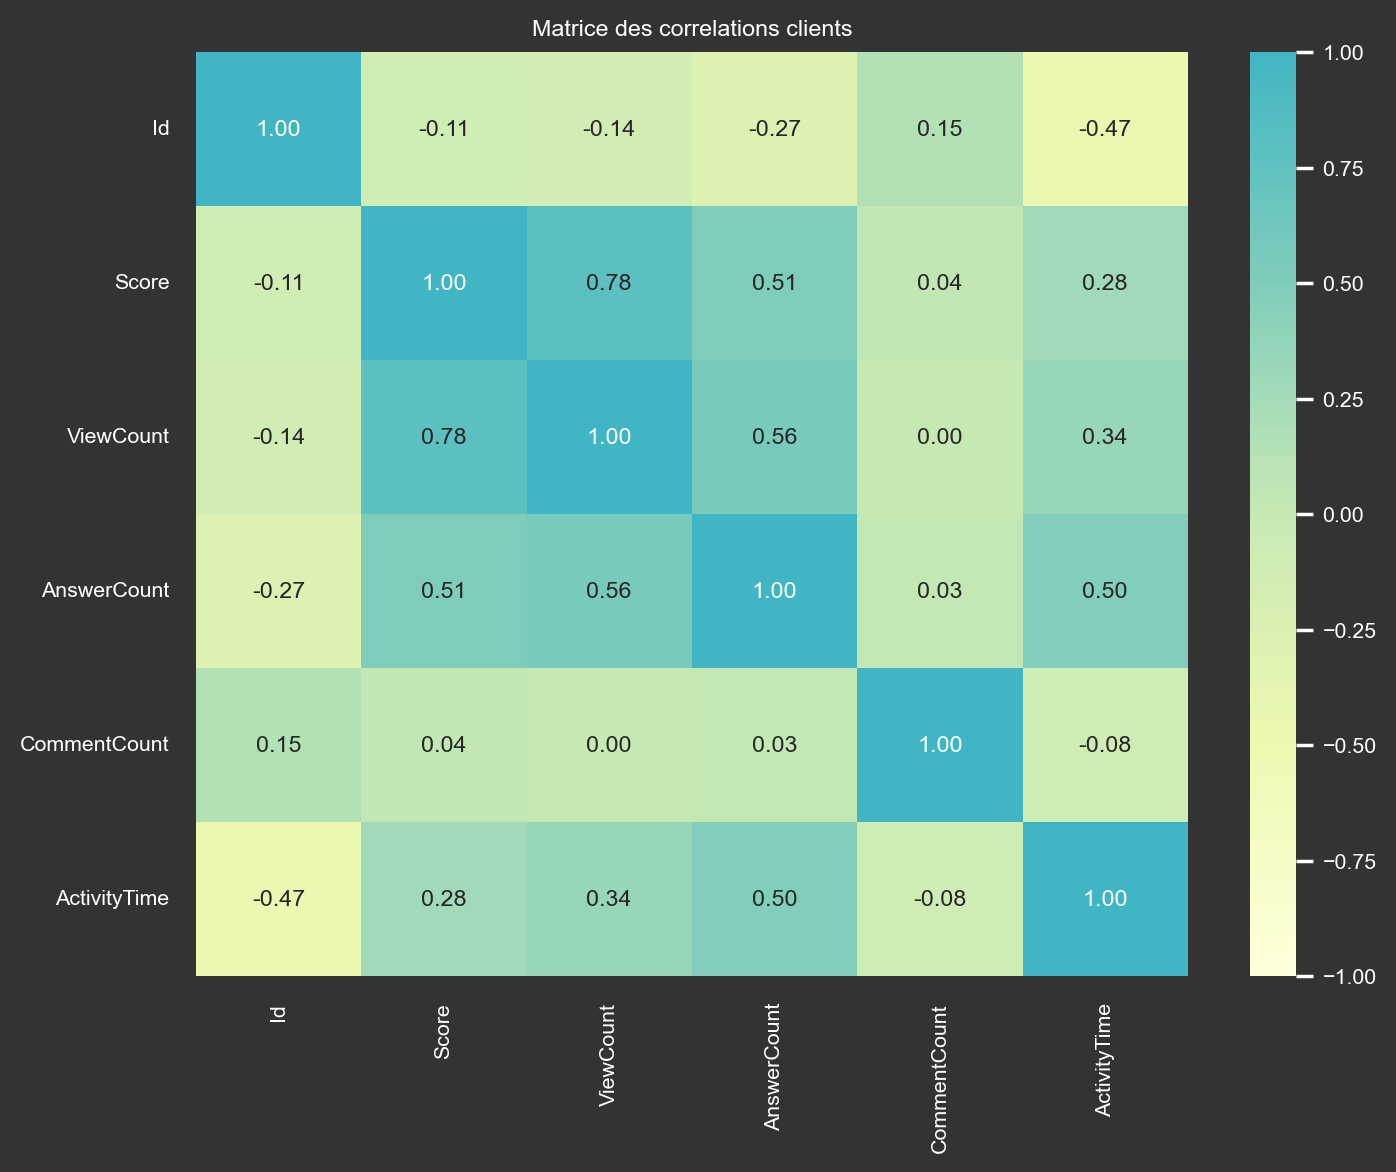

In [73]:
sns.set(font_scale = 0.7, rc = {'axes.labelcolor': 'white', 
'xtick.color': 'white', 'ytick.color': 'white'})
plt.title("Matrice des correlations clients", color = 'white')

sns.heatmap(df.corr(), center = 1, annot = True, 
fmt = ".2f", vmin =- 1, vmax = 1, cmap = 'YlGnBu')

# Ajouter une bordure personnalisée avec une couleur de fond grise
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.patch.set_facecolor('0.2')

plt.show()

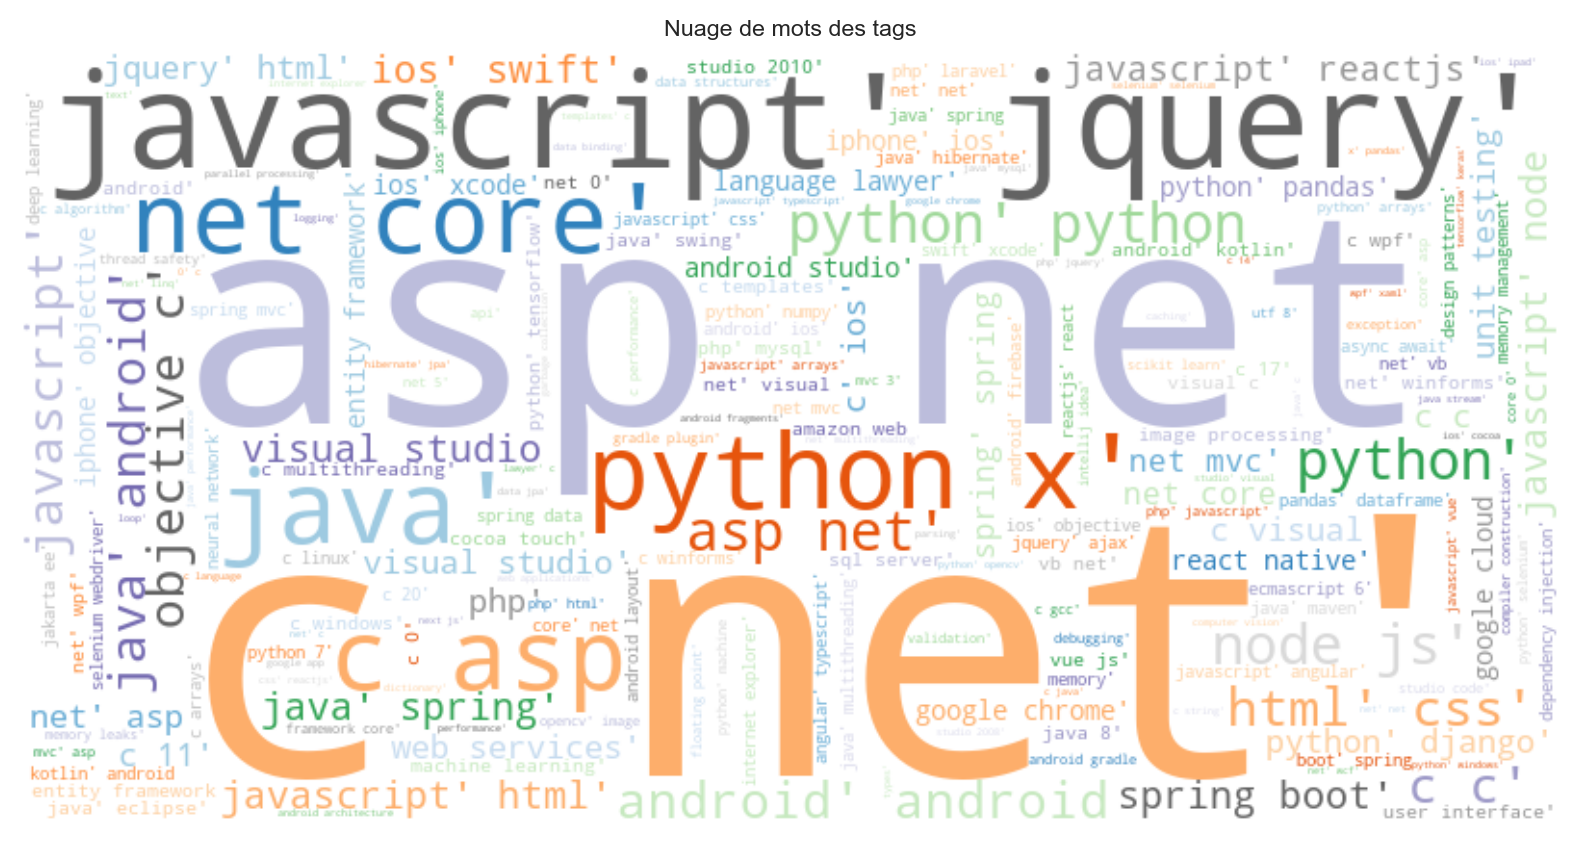

In [78]:
# Concaténer tous les tags en une seule chaîne de caractères
all_tags = ' '.join(df['Tags'].astype(str))

# Créer un objet WordCloud avec les paramètres souhaités
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(all_tags)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des tags')
plt.show()

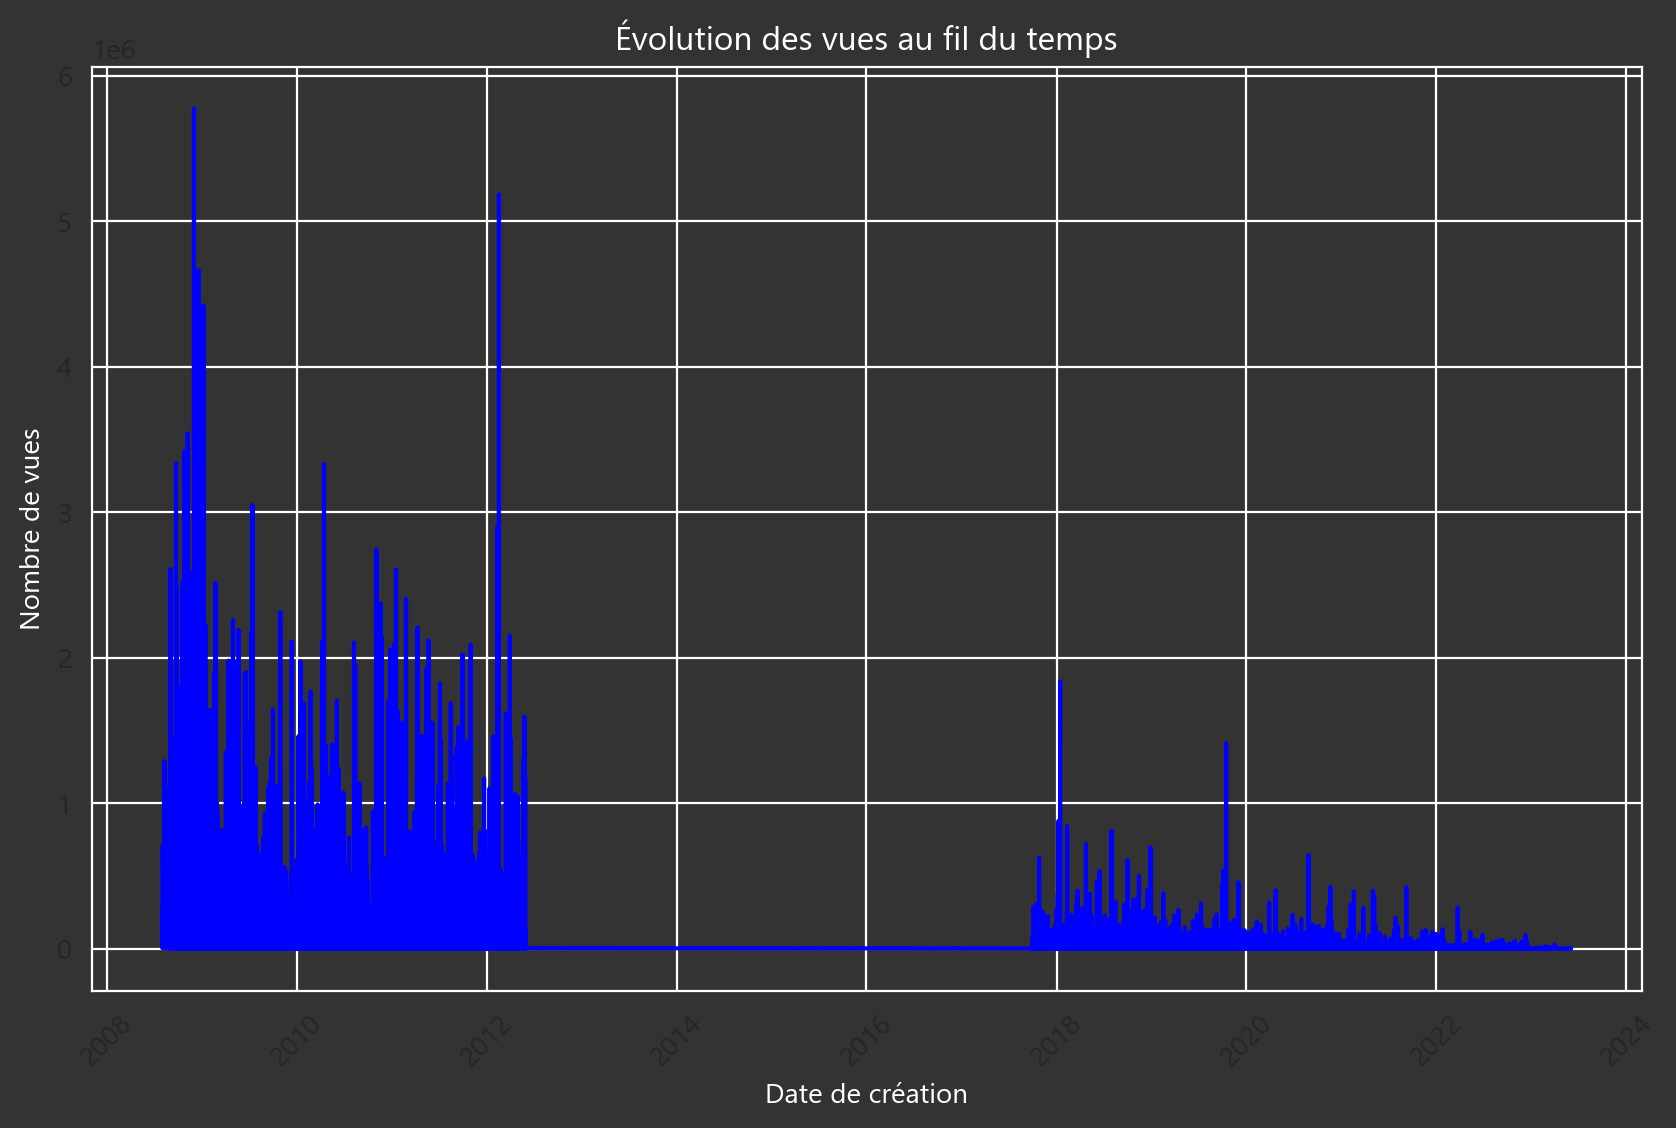

In [20]:
# Trier les données par 'CreationDate'
df = df.sort_values('CreationDate')

# Tracer le graphique de l'évolution des vues au fil du temps
plt.figure(figsize=(10, 6))
plt.plot(df['CreationDate'], df['ViewCount'], color='b')
plt.title("Évolution des vues au fil du temps")
plt.xlabel("Date de création")
plt.ylabel("Nombre de vues")
plt.xticks(rotation=45)  # Faire pivoter les étiquettes de l'axe des x pour une meilleure lisibilité
plt.grid(True)
plt.show()

In [21]:
df.dtypes

Title                       object
Tags                        object
Id                           int64
Score                        int64
ViewCount                    int64
AnswerCount                  int64
CreationDate        datetime64[ns]
LastActivityDate    datetime64[ns]
CommentCount                 int64
body_clean                  object
main_tag                    object
ActivityTime                 int64
dtype: object

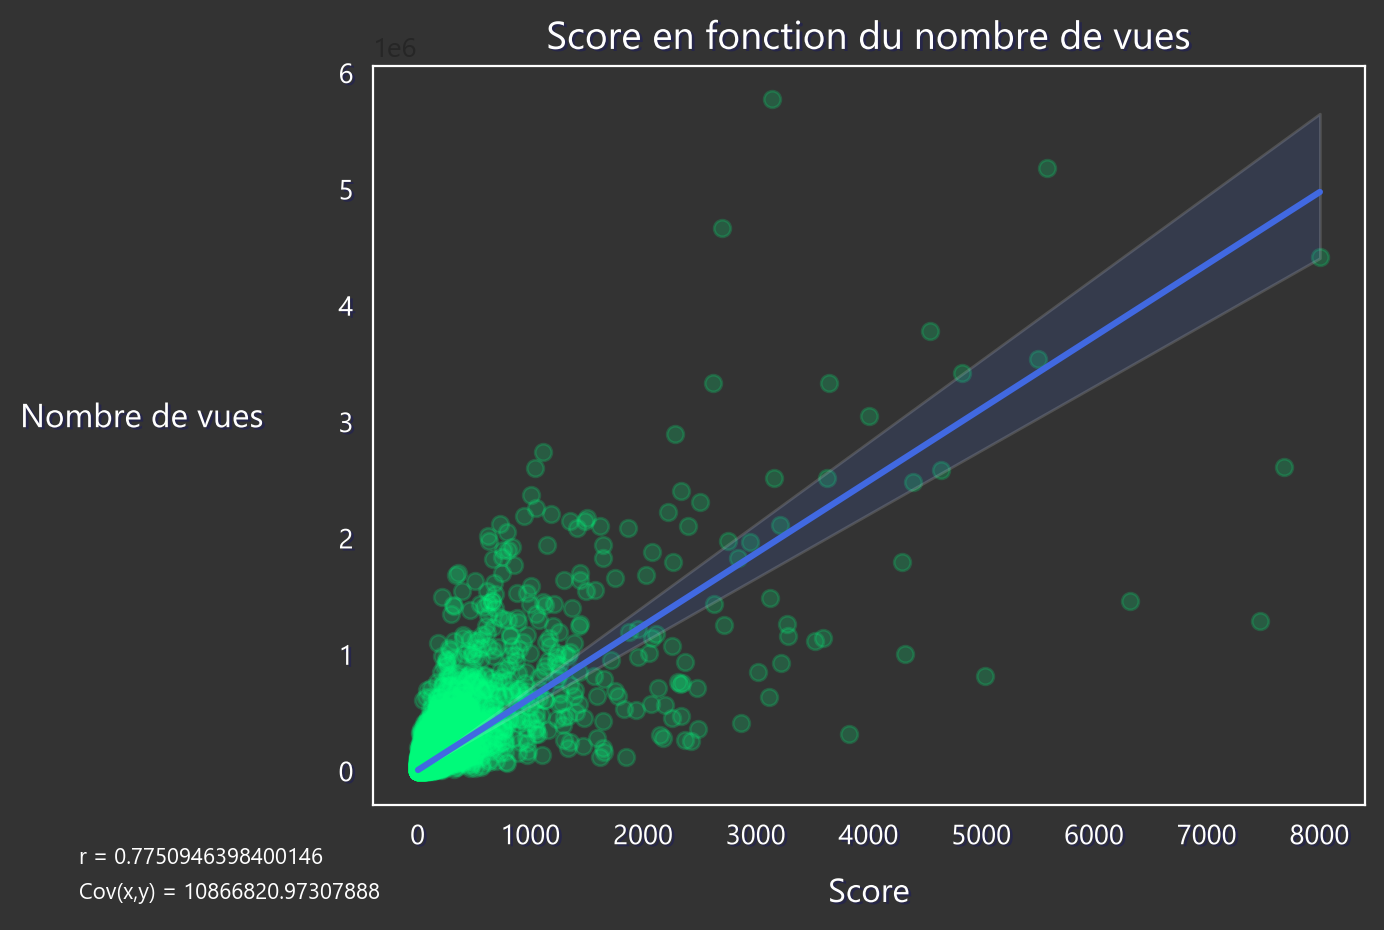

In [31]:
# on stocke la valeur du coefficient de pearson dans une variable
r_value = st.pearsonr(df["Score"], df["ViewCount"])[0]
# même chose pour la covariance
cov_value = np.cov(df["Score"], df["ViewCount"], ddof = 0)[1,0]

#customisation du graph
plt.title("Score en fonction du nombre de vues", fontsize = 14)
plt.xticks(fontsize = 10, color = 'white')
plt.yticks(fontsize = 10, color = 'white')

ax = sns.regplot(x = "Score", y = "ViewCount", data = df, 
color = 'springgreen', line_kws = {"color":"royalblue"}, 
scatter_kws = {"alpha":0.2, "edgecolor":"springgreen"}, marker = 'o')

plt.xlabel("Score", color = 'white', size = 12, labelpad = 10)
plt.gca().yaxis.set_label_coords( - 0.233, 0.5)
plt.ylabel("Nombre de vues", color = 'white', size = 12, rotation = 360)
plt.text( - 3000,  - 800000, 'r = {}'.format(r_value), color = 'white', size = 8)
plt.text( - 3000,  - 1100000, 'Cov(x,y) = {}'.format(cov_value), 
color = 'white', size = 8)
ax.grid(False)
# Appliquer les effets de texte aux titres
for title in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    title.set_path_effects([shadow])

# Appliquer les effets de texte aux ticks
for tick in ax.xaxis.get_ticklabels() + ax.yaxis.get_ticklabels():
    tick.set_path_effects([shadow])
plt.show()

In [5]:
df

,Title,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount,body_clean,main_tag,ActivityTime
0,How to convert Decimal to Double in C#?,"['c#', 'floating-point', 'type-conversion', 'd...",4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4,want assign decimal variable double variable d...,c#,5151
1,Calculate relative time in C#,"['c#', 'datetime', 'time', 'datediff', 'relati...",11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3,given specific value display relative time lik...,c#,5148
2,Determine a user's timezone,"['html', 'browser', 'timezone', 'user-agent', ...",13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10,standard way web server able determine user ti...,html,4988
3,How to use the C socket API in C++ on z/OS,"['c++', 'c', 'sockets', 'mainframe', 'zos']",25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1,issue getting c socket work properly c althoug...,c++,5416
4,Decoding T-SQL CAST in C#/VB.NET,"['c#', 'sql', 'vb.net', 'ascii', 'hex']",109,68,6106,2,2008-08-01 15:23:05,2019-02-10 22:11:00,3,recently site deluged resurgence botnet inject...,c#,3845
...,...,...,...,...,...,...,...,...,...,...,...,...
66764,Bootstrap 4 - Nav - Hiding extra menu items,"['jquery', 'html', 'css', 'twitter-bootstrap',...",46477802,17,16932,7,2017-09-28 20:31:08,2019-03-17 11:49:07,4,bootstrap 4 layout similar many nav item want ...,html,534
66765,Check std::vector has duplicates,"['c++', 'algorithm', 'for-loop', 'vector', 'du...",46477764,19,51315,7,2017-09-28 20:27:39,2022-06-29 10:51:43,11,want check vector integer duplicate return tru...,c++,1734
66766,Python subprocess check_output decoding specia...,"['python', 'python-3.x', 'character-encoding',...",46476677,6,9223,1,2017-09-28 19:13:38,2017-09-28 19:34:10,9,issue python encoding try execute give output ...,python,0
66767,"In electron, how to upload a file from it's fu...","['javascript', 'node.js', 'file-upload', 'elec...",46476474,4,3954,1,2017-09-28 18:58:53,2018-06-27 13:57:05,3,electron app button say upload contract clicke...,javascript,271


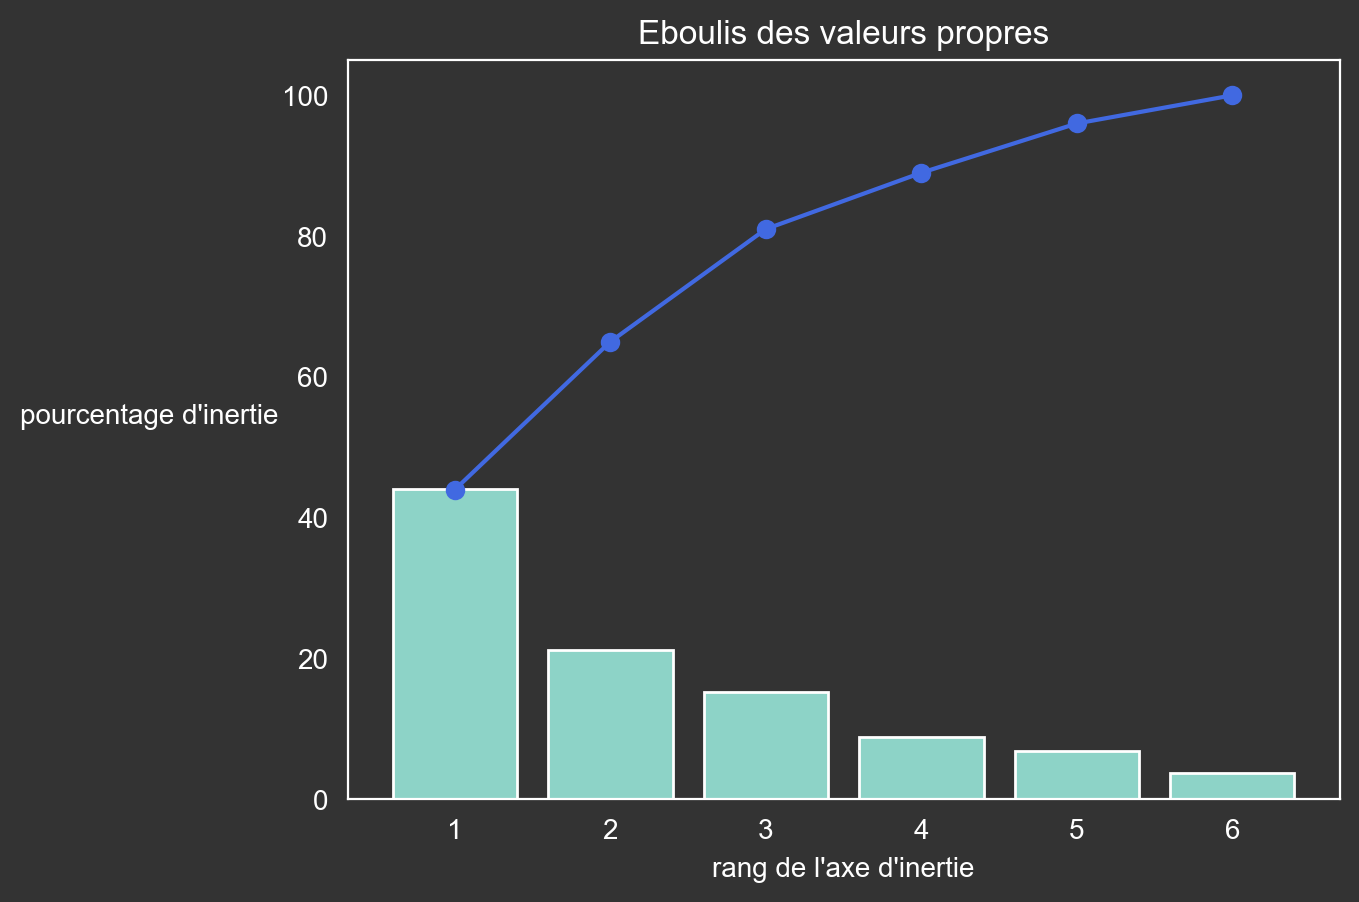

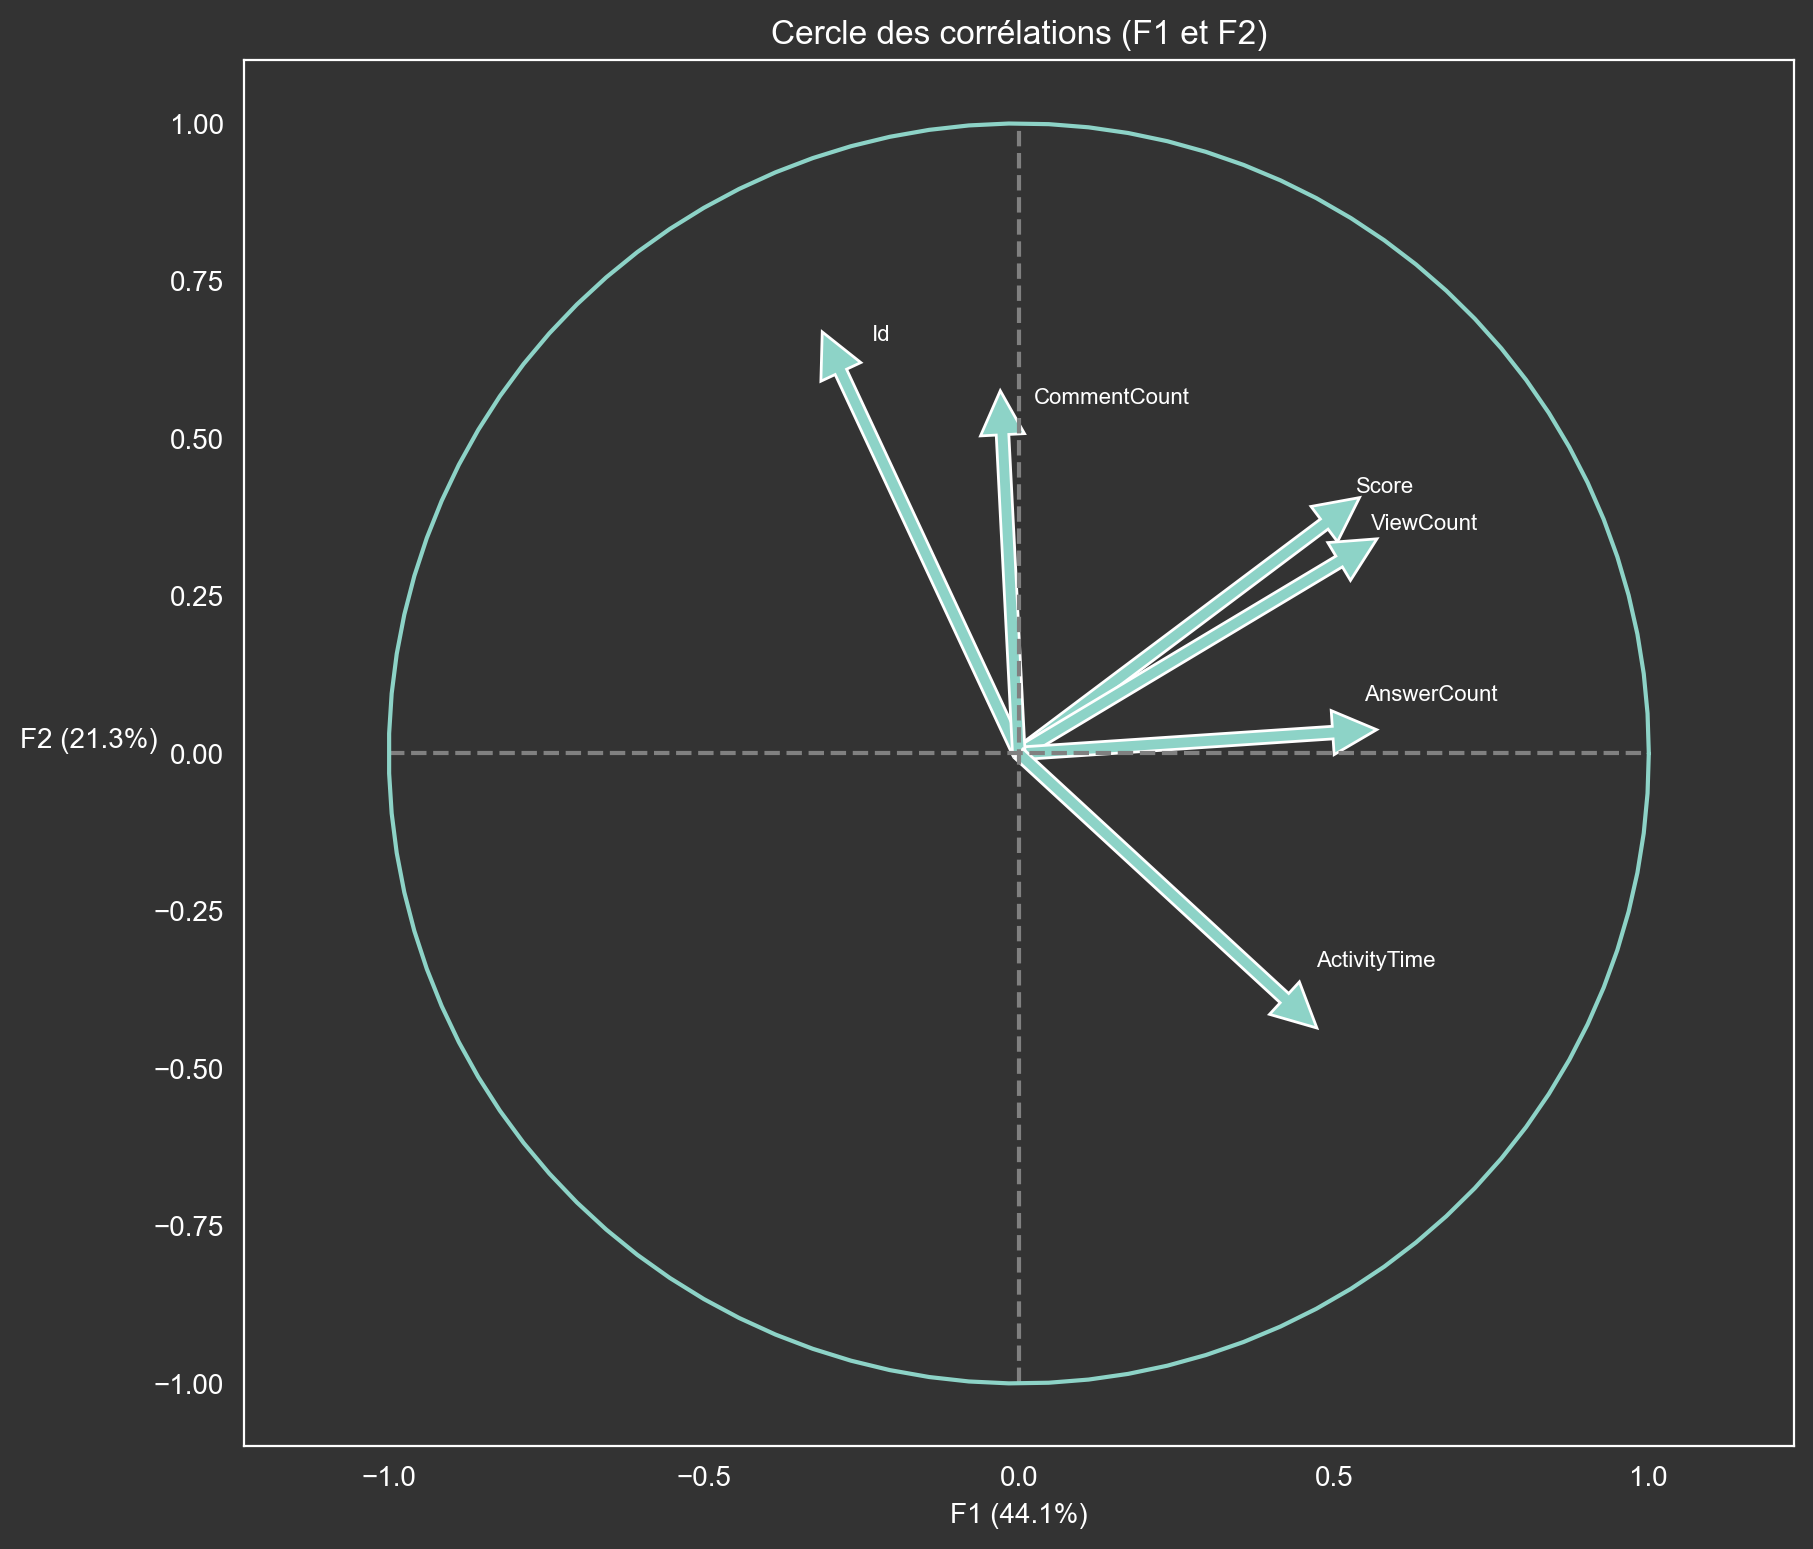

In [6]:
# suppression des variables non numériques
df_pca = df.select_dtypes(include = [np.number])
# df_pca = df_pca.drop(columns = [''])
X = df_pca.values
names = df_pca.index
features = df_pca.columns

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# préciser le nombre de components
n_components = 6

# Créer un objet PCA avec le nombre de composantes souhaité
pca = PCA(n_components = n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_ * 100).round(2)
scree

# on arrondit à la somme cumulée
scree_cum = scree.cumsum().round()
scree_cum

x_list = range(1, n_components + 1)
list(x_list)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c = "royalblue",marker = 'o')
plt.xlabel("rang de l'axe d'inertie", color = 'white')
plt.gca().yaxis.set_label_coords( - 0.2, 0.5)
plt.ylabel("pourcentage d'inertie", color = 'white', rotation = 360)
plt.title("Eboulis des valeurs propres", color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.grid(False)
plt.show(block = False)
x, y = 0, 1
fig, ax = plt.subplots(figsize = (10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
        0,  # Start the arrow at the origin
        pca.components_[0, i],  #0 for PC1
        pca.components_[1, i],  #1 for PC2
        head_width = 0.07,
        head_length = 0.07, 
        width = 0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
        pca.components_[1, i] + 0.05,
        features[i], fontsize = 8)
    
# affichage des lignes horizontales et verticales
plt.plot([ - 1, 1], [0, 0], color = 'grey', ls = '--')
plt.plot([0, 0], [ - 1, 1], color = 'grey', ls = '--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x + 1, 
round(100 * pca.explained_variance_ratio_[x], 1)), color = 'white')
plt.ylabel('F{} ({}%)'.format(y + 1, round(
100 * pca.explained_variance_ratio_[y],1)), color = 'white', rotation = 360)

plt.title("Cercle des corrélations (F{} et F{})".format(x + 1, y + 1))
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.gca().yaxis.set_label_coords( - 0.1, 0.5)
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.grid(False)
plt.show(block = False)